In [185]:
import pandas as pd
import random
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from scipy.stats import randint, uniform
from sklearn.utils.class_weight import compute_class_weight

In [186]:
pd.set_option('display.max_columns', 40)

In [187]:
def seed_everything(seed):
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    
seed_everything(37)

In [188]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'AppleGothic'

elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rcParams["font.family"] = font_name
elif platform.system() == 'Linux':
    plt.rcParams['font.family'] = 'NanumGothic'


plt.rcParams['axes.unicode_minus'] = False

In [189]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Data Preprocessing

## 결측치 개수 변수 생성

In [190]:
ttrain3 = train.copy()

In [191]:
ttrain4 = ttrain3.copy()
ttrain4 = ttrain4.drop(columns = ['허위매물여부'], axis = 1)
# 결측 여부를 이진 변수로 변환
for col in ttrain4.columns:
    ttrain4[f'{col}'] = ttrain4[col].isna().astype(int)
ttrain4    

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일
0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2448,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2450,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [192]:
ttrain4['결측치개수'] = ttrain4.sum(axis = 1)

In [193]:
ttrain4.결측치개수.unique()

array([2, 0, 1, 6, 3, 5])

In [194]:
ttrain3['결측치개수'] = ttrain4['결측치개수']

In [195]:
ttest = test.copy()
# 결측 여부를 이진 변수로 변환
for col in ttest.columns:
    ttest[f'{col}'] = ttest[col].isna().astype(int)
    
ttest['결측치개수'] = ttest.sum(axis = 1)

In [196]:
ttest.결측치개수.unique()

array([2, 0, 1, 3, 6, 5])

In [197]:
test['결측치개수'] = ttest['결측치개수']

## 전용면적 예측하기 KNN

In [208]:
train[train.허위매물여부==1]

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1
12,TRAIN_0012,전화확인,348500000.0,180000,23.14,2.0,5.0,동향,1.0,1.0,불가능,NaN,0,J30yG7F1O0,C플랫폼,2024-07-15,1
22,TRAIN_0022,현장확인,24500000.0,740000,29.50,7.0,8.0,남서향,1.0,1.0,가능,1.0,4,W88DA3W2Q3,A플랫폼,2024-05-12,1
31,TRAIN_0031,현장확인,132000000.0,540000,NaN,2.0,3.0,서향,1.0,1.0,불가능,NaN,8,Z18up3D1C3,A플랫폼,2024-07-10,1
47,TRAIN_0047,현장확인,76000000.0,700000,NaN,3.0,5.0,서향,1.0,1.0,불가능,NaN,6,m69GM9O9B3,B플랫폼,2023-12-19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,TRAIN_2408,현장확인,81500000.0,310000,NaN,4.0,6.0,북향,2.0,1.0,불가능,4.0,13,j96GJ1G2T3,D플랫폼,2023-08-16,1
2411,TRAIN_2411,현장확인,341000000.0,550000,NaN,5.0,6.0,남서향,1.0,1.0,불가능,NaN,15,S12iP7V0Q9,A플랫폼,2024-06-18,1
2415,TRAIN_2415,현장확인,26500000.0,570000,NaN,3.0,4.0,북동향,2.0,1.0,불가능,NaN,0,D25dP0R4Q9,D플랫폼,2024-05-06,1
2418,TRAIN_2418,전화확인,343000000.0,470000,21.70,2.0,7.0,남향,1.0,1.0,불가능,NaN,14,a15xR3G4V0,A플랫폼,2024-07-04,1


In [198]:
ttrain5 = train.copy()

In [199]:
ttrain5 = ttrain5[['전용면적', '보증금', '월세', '관리비','허위매물여부']]
ttrain5

,전용면적,보증금,월세,관리비,허위매물여부
0,NaN,402500000.0,470000,96,0
1,NaN,170500000.0,200000,0,0
2,NaN,114000000.0,380000,0,0
3,36.30,163500000.0,30000,10,0
4,NaN,346000000.0,530000,0,1
...,...,...,...,...,...
2447,48.95,159000000.0,550000,0,0
2448,NaN,158500000.0,750000,2,0
2449,17.50,329000000.0,610000,10,0
2450,22.87,31000000.0,400000,8,0


In [200]:
# ttrain5 = ttrain5[~(ttrain5[['총층', '해당층']].isna().any(axis=1))]
# ttrain5

In [201]:
ttrain5 = ttrain5[ttrain5['허위매물여부']==0]
ttrain5

,전용면적,보증금,월세,관리비,허위매물여부
0,NaN,402500000.0,470000,96,0
1,NaN,170500000.0,200000,0,0
2,NaN,114000000.0,380000,0,0
3,36.30,163500000.0,30000,10,0
5,29.50,153000000.0,530000,0,0
...,...,...,...,...,...
2447,48.95,159000000.0,550000,0,0
2448,NaN,158500000.0,750000,2,0
2449,17.50,329000000.0,610000,10,0
2450,22.87,31000000.0,400000,8,0


최적의 n_neighbors 값: 17


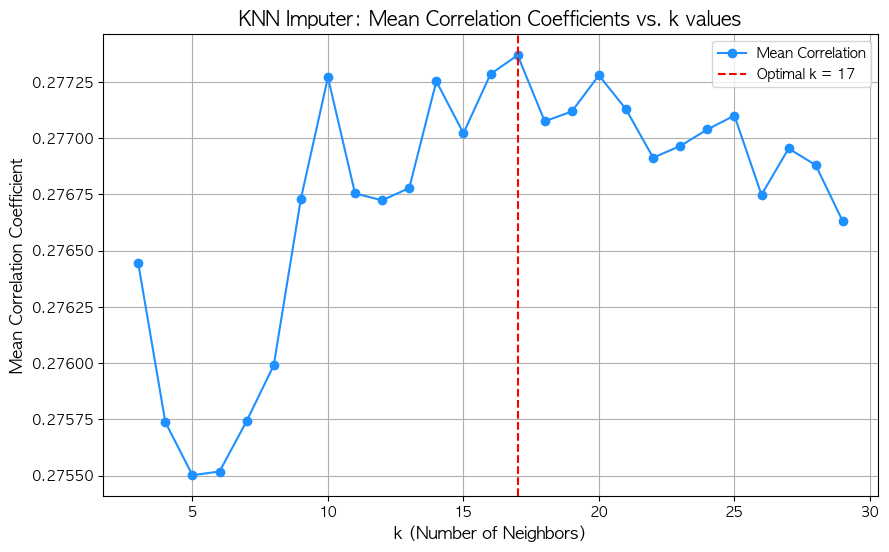

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# k 값 범위 설정 (3~20)
k_values = list(range(3, 30))

# 상관계수 저장할 딕셔너리
correlation_results = {}

# 원본 데이터 복사
ttrain5_copy = ttrain5.drop(columns = ['허위매물여부'], axis = 1)

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    ttrain5_imputed = pd.DataFrame(imputer.fit_transform(ttrain5_copy), columns=ttrain5_copy.columns)

    # Pearson 상관계수 계산
    corr_matrix = ttrain5_imputed.corr(method='pearson')
    mean_corr = corr_matrix.abs().mean().mean()  # 절대값 평균 상관계수 저장
    correlation_results[k] = mean_corr

# 최적 k 찾기
optimal_k = max(correlation_results, key=correlation_results.get)
print(f"최적의 n_neighbors 값: {optimal_k}")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(correlation_results.keys(), correlation_results.values(), marker='o', linestyle='-', color='dodgerblue', label="Mean Correlation")
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.title("KNN Imputer: Mean Correlation Coefficients vs. k values", fontsize=14)
plt.xlabel("k (Number of Neighbors)", fontsize=12)
plt.ylabel("Mean Correlation Coefficient", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [203]:
from sklearn.impute import KNNImputer

print(ttrain5_copy.shape)
t5_index = ttrain5_copy.index

imputer = KNNImputer(n_neighbors=17)
ttrain5_imputed = imputer.fit_transform(ttrain5_copy)

ttrain5 = pd.DataFrame(ttrain5_imputed, index=t5_index)
ttrain5.columns = ['전용면적', '보증금', '월세', '관리비']
ttrain5.index = t5_index
print(ttrain5.shape)
ttrain5

(2154, 4)
(2154, 4)


,전용면적,보증금,월세,관리비
0,26.830000,402500000.0,470000.0,96.0
1,24.623462,170500000.0,200000.0,0.0
2,24.895385,114000000.0,380000.0,0.0
3,36.300000,163500000.0,30000.0,10.0
5,29.500000,153000000.0,530000.0,0.0
...,...,...,...,...
2447,48.950000,159000000.0,550000.0,0.0
2448,28.510385,158500000.0,750000.0,2.0
2449,17.500000,329000000.0,610000.0,10.0
2450,22.870000,31000000.0,400000.0,8.0


In [204]:
ttrain3['전용면적'] = ttrain5['전용면적']

In [205]:
print(f"이전 데이터프레임 길이 : {len(ttrain3)}" )
ttrain3 = ttrain3.dropna(subset = ['전용면적', '월세', '보증금'], how = 'any')
print(f"이후 데이터프레임 길이 : {len(ttrain3)}" )

이전 데이터프레임 길이 : 2452
이후 데이터프레임 길이 : 2154


In [209]:
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,결측치개수
0,TRAIN_0000,현장확인,402500000.0,470000,26.830000,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0,2
1,TRAIN_0001,현장확인,170500000.0,200000,24.623462,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0,2
2,TRAIN_0002,전화확인,114000000.0,380000,24.895385,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0,2
3,TRAIN_0003,현장확인,163500000.0,30000,36.300000,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,0
5,TRAIN_0005,전화확인,153000000.0,530000,29.500000,NaN,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,TRAIN_2447,서류확인,159000000.0,550000,48.950000,3.0,3.0,남향,2.0,1.0,불가능,NaN,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,1
2448,TRAIN_2448,서류확인,158500000.0,750000,28.510385,2.0,4.0,남향,1.0,1.0,불가능,NaN,2,g99sy3I3R8,A플랫폼,2024-10-06,0,2
2449,TRAIN_2449,전화확인,329000000.0,610000,17.500000,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,0
2450,TRAIN_2450,현장확인,31000000.0,400000,22.870000,8.0,9.0,남동향,2.0,1.0,가능,NaN,8,m69GM9O9B3,B플랫폼,2024-08-06,0,1


In [210]:
ttrain3_ = train[train.허위매물여부==1]

In [212]:
ttrain3_.index

Index([   4,   12,   22,   31,   47,   48,   93,  106,  117,  118,
       ...
       2386, 2391, 2392, 2401, 2403, 2408, 2411, 2415, 2418, 2441],
      dtype='int64', length=298)

In [213]:
ttrain3.index

Index([   0,    1,    2,    3,    5,    6,    7,    8,    9,   10,
       ...
       2386, 2391, 2392, 2401, 2403, 2408, 2411, 2415, 2418, 2441],
      dtype='int64', length=2452)

In [211]:
ttrain3 = pd.concat([ttrain3, ttrain3_], axis = 0)
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,결측치개수
0,TRAIN_0000,현장확인,402500000.0,470000,26.830000,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0,2.0
1,TRAIN_0001,현장확인,170500000.0,200000,24.623462,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0,2.0
2,TRAIN_0002,전화확인,114000000.0,380000,24.895385,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0,2.0
3,TRAIN_0003,현장확인,163500000.0,30000,36.300000,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,0.0
5,TRAIN_0005,전화확인,153000000.0,530000,29.500000,NaN,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,TRAIN_2408,현장확인,81500000.0,310000,NaN,4.0,6.0,북향,2.0,1.0,불가능,4.0,13,j96GJ1G2T3,D플랫폼,2023-08-16,1,NaN
2411,TRAIN_2411,현장확인,341000000.0,550000,NaN,5.0,6.0,남서향,1.0,1.0,불가능,NaN,15,S12iP7V0Q9,A플랫폼,2024-06-18,1,NaN
2415,TRAIN_2415,현장확인,26500000.0,570000,NaN,3.0,4.0,북동향,2.0,1.0,불가능,NaN,0,D25dP0R4Q9,D플랫폼,2024-05-06,1,NaN
2418,TRAIN_2418,전화확인,343000000.0,470000,21.700000,2.0,7.0,남향,1.0,1.0,불가능,NaN,14,a15xR3G4V0,A플랫폼,2024-07-04,1,NaN


In [214]:
ttrain3 = ttrain3.sort_index()
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,결측치개수
0,TRAIN_0000,현장확인,402500000.0,470000,26.830000,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0,2.0
1,TRAIN_0001,현장확인,170500000.0,200000,24.623462,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0,2.0
2,TRAIN_0002,전화확인,114000000.0,380000,24.895385,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0,2.0
3,TRAIN_0003,현장확인,163500000.0,30000,36.300000,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,0.0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,TRAIN_2447,서류확인,159000000.0,550000,48.950000,3.0,3.0,남향,2.0,1.0,불가능,NaN,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,1.0
2448,TRAIN_2448,서류확인,158500000.0,750000,28.510385,2.0,4.0,남향,1.0,1.0,불가능,NaN,2,g99sy3I3R8,A플랫폼,2024-10-06,0,2.0
2449,TRAIN_2449,전화확인,329000000.0,610000,17.500000,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,0.0
2450,TRAIN_2450,현장확인,31000000.0,400000,22.870000,8.0,9.0,남동향,2.0,1.0,가능,NaN,8,m69GM9O9B3,B플랫폼,2024-08-06,0,1.0


In [215]:
numeric_cols = [col for col in ttrain3.select_dtypes(include=['number']).columns if col != '허위매물여부']
train_medians = ttrain3[numeric_cols].median()

In [216]:
ttrain3[numeric_cols] = ttrain3[numeric_cols].fillna(ttrain3[numeric_cols].median())

In [217]:
# 테스트 데이터에 적용
test[numeric_cols] = test[numeric_cols].fillna(train_medians)

## 계층적 클러스터링

In [218]:
from sklearn.preprocessing import StandardScaler

X_m = ttrain3[['전용면적', '방수', '욕실수']]

scaler = StandardScaler()
X_m_scaled = scaler.fit_transform(X_m)

/var/folders/rc/3jzqjhp56_v2qxb49fkb1x880000gn/T/ipykernel_1241/2866546436.py:6: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


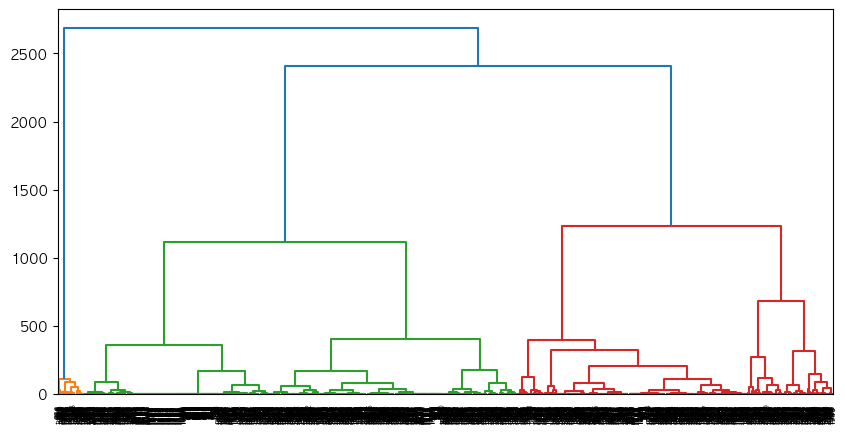

In [219]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import nan_euclidean_distances

distance_matrix = nan_euclidean_distances(X_m_scaled)
linkage_matrix = linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.show()

In [220]:
from scipy.cluster.hierarchy import fcluster

# 클러스터 개수를 6개로 설정하여 데이터 분류
labels = fcluster(linkage_matrix, t=6, criterion='maxclust')

print("클러스터 라벨:", labels, "/", len(labels))

클러스터 라벨: [3 4 3 ... 2 4 4] / 2452


In [221]:
# Hierarchical Clustering
property_hierarchical_clustering = pd.Series(labels)
property_hierarchical_clustering.index = ttrain3.index
ttrain3["매물_HC"] = property_hierarchical_clustering
ttrain3["매물_HC"].value_counts()

매물_HC
3    785
4    725
2    588
6    158
5    112
1     84
Name: count, dtype: int64

knn을 이용해 훈련데이터의 클러스터링에 맞게 테스트 데이터에도 수행

In [222]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # k=5 (클러스터개수와 상관x)
knn.fit(X_m_scaled, ttrain3['매물_HC'])

# 테스트 데이터 변환 및 예측
X_test = test[['전용면적', '방수', '욕실수']]
X_test_scaled = scaler.transform(X_test)  #train에서 학습한 scaler 사용

In [223]:
test["매물_HC"] = knn.predict(X_test_scaled)
test["매물_HC"].value_counts()

매물_HC
3    198
4    193
2    133
6     37
5     31
1     21
Name: count, dtype: int64

In [224]:
X_test

,전용면적,방수,욕실수
0,26.821154,1.0,1.0
1,30.260000,1.0,1.0
2,41.500000,2.0,1.0
3,31.350000,2.0,1.0
4,23.140000,1.0,1.0
...,...,...,...
608,30.830000,1.0,1.0
609,29.880000,2.0,1.0
610,30.730000,1.0,1.0
611,17.500000,1.0,1.0


In [225]:
# import pickle

# with open("./project/saved/scaler.pkl", "wb") as file:
#     pickle.dump(scaler, file)

# with open("./project/saved/knn_hc.pkl", "wb") as file:
#     pickle.dump(knn, file)

## DBSCAN

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# DBSCAN 적용 / 클러스터 6개로 하려면 eps = 0.128
dbscan = DBSCAN(eps=0.1, min_samples=6) #eps : 두 데이터 포인트가 같은 클러스터에 속할 수 있는 최대 거리(밀집 기준)
y_dbscan = dbscan.fit_predict(X_m_scaled)
ttrain3['매물_DBSCAN'] = y_dbscan

In [227]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# 노이즈(-1) 데이터 찾기
noise_mask = (y_dbscan == -1)
non_noise_mask = ~noise_mask

# 노이즈가 아닌 데이터로 KNN 학습
knn_dbscan = KNeighborsClassifier(n_neighbors=5)
knn_dbscan.fit(X_m_scaled[non_noise_mask], y_dbscan[non_noise_mask])

# 노이즈 데이터에 대해 KNN으로 클러스터 배정
y_dbscan_filled = y_dbscan.copy()
y_dbscan_filled[noise_mask] = knn_dbscan.predict(X_m_scaled[noise_mask])
ttrain3['매물_DBSCAN'] = y_dbscan_filled
ttrain3['매물_DBSCAN'].value_counts() #노이즈 ID : -1

매물_DBSCAN
0     1520
1      772
2       33
4       23
5       15
3       14
7       14
9       13
8       11
11      11
10      10
12       9
6        7
Name: count, dtype: int64

훈련 데이터에서 노이즈 데이터를 각 클러스터에 배정하기 위해 사용한 knn_dbscan을 가지고 테스트데이터에도 적용

In [228]:
# KNN을 활용하여 테스트 데이터의 클러스터 할당
test['매물_DBSCAN'] = knn_dbscan.predict(X_test_scaled)  # KNN 기반 클러스터 배정
test['매물_DBSCAN'].value_counts()

매물_DBSCAN
0     362
1     212
2      11
9       6
7       6
8       6
10      4
5       2
3       2
11      1
4       1
Name: count, dtype: int64

In [229]:
# import pickle

# with open("./project/saved/knn_dbscan.pkl", "wb") as file:
#     pickle.dump(knn_dbscan, file)

월세와 보증금 **만단위**로 바꾸기 / **보증금_월세관리비_비율** 변수 **전용면적_가격_비율** 변수 생성

In [230]:
ttrain3["보증금"] = ttrain3["보증금"] / 10000
ttrain3["월세"] = ttrain3["월세"] / 10000
ttrain3['월세+관리비']  = ttrain3['월세'] + ttrain3['관리비']

In [231]:
ttrain3['보증금_월세관리비_비율'] = ttrain3['월세+관리비'] / ttrain3['보증금']
ttrain3['전용면적_가격_비율'] = ttrain3['보증금_월세관리비_비율'] / ttrain3['전용면적']

In [232]:
test["보증금"] = test["보증금"] / 10000
test["월세"] = test["월세"] / 10000
test['월세+관리비']  = test['월세'] + test['관리비']

In [233]:
test['보증금_월세관리비_비율'] = test['월세+관리비'] / test['보증금']
test['전용면적_가격_비율'] = test['보증금_월세관리비_비율'] / test['전용면적']

## KMedoids

In [234]:
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# 데이터 스케일링
X_m2 = ttrain3[['매물_HC','매물_DBSCAN', '전용면적_가격_비율', '보증금_월세관리비_비율']]
scaler2 = StandardScaler()
X_m_scaled2 = scaler2.fit_transform(X_m2)

In [235]:
# K-Medoids
kmedoids = KMedoids(n_clusters=11, random_state=42)
ttrain3['지역_KMedoids'] = kmedoids.fit_predict(X_m_scaled2)
ttrain3['지역_KMedoids'].value_counts()

지역_KMedoids
5     828
6     376
0     220
3     211
7     183
8     164
10    147
4      87
1      83
9      78
2      75
Name: count, dtype: int64

In [236]:
from sklearn.neighbors import KNeighborsClassifier

knn_kmedoids = KNeighborsClassifier(n_neighbors=5)  # k=5
knn_kmedoids.fit(X_m_scaled2, ttrain3['지역_KMedoids'])

# 테스트 데이터 변환 및 예측
X_test2 = test[['매물_HC','매물_DBSCAN', '전용면적_가격_비율', '보증금_월세관리비_비율']]
X_test_scaled2 = scaler2.transform(X_test2)  # train에서 학습한 scaler 사용
test["지역_KMedoids"] = knn_kmedoids.predict(X_test_scaled2)  # KNN 기반 클러스터 배정
test['지역_KMedoids'].value_counts()


지역_KMedoids
5     224
6      86
0      67
3      55
7      54
8      42
10     35
4      20
1      18
2       6
9       6
Name: count, dtype: int64

In [237]:
# import pickle

# with open("./project/saved/scaler2.pkl", "wb") as file:
#     pickle.dump(scaler2, file)

# with open("./project/saved/knn_kmedoids.pkl", "wb") as file:
#     pickle.dump(knn_kmedoids, file)

## HDBSCAN

In [238]:
import hdbscan

# HDBSCAN 클러스터링 수행
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon = 0.2)
y_hdbscan = hdb.fit_predict(X_m_scaled2)
ttrain3['지역_HDBSCAN'] = y_hdbscan

# 클러스터 개수 확인
ttrain3['지역_HDBSCAN'].value_counts()

지역_HDBSCAN
 13    766
 11    683
 9     580
 8     119
 10     75
-1      60
 2      30
 6      27
 7      20
 0      20
 3      19
 1      18
 4      13
 12     11
 5      11
Name: count, dtype: int64

In [239]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# 노이즈(-1) 데이터 찾기
noise_mask = (y_hdbscan == -1)
non_noise_mask = ~noise_mask

# 노이즈가 아닌 데이터로 KNN 학습
knn_hdbscan = KNeighborsClassifier(n_neighbors=5)
knn_hdbscan.fit(X_m_scaled2[non_noise_mask], y_hdbscan[non_noise_mask])

# 노이즈 데이터에 대해 KNN으로 클러스터 배정
y_hdbscan_filled = y_hdbscan.copy()
y_hdbscan_filled[noise_mask] = knn_hdbscan.predict(X_m_scaled2[noise_mask])
ttrain3['지역_HDBSCAN'] = y_hdbscan_filled
ttrain3['지역_HDBSCAN'].value_counts() #노이즈 ID : -1

지역_HDBSCAN
13    767
11    697
9     587
8     119
10     76
12     33
2      33
6      31
7      22
0      22
3      20
1      19
4      14
5      12
Name: count, dtype: int64

In [240]:
from sklearn.neighbors import KNeighborsClassifier

# KNN을 활용하여 테스트 데이터의 클러스터 할당
test['지역_HDBSCAN'] = knn_hdbscan.predict(X_test_scaled2)  # KNN 기반 클러스터 배정

test['지역_HDBSCAN'].value_counts()


지역_HDBSCAN
13    198
11    191
9     132
8      26
10     20
2      13
6      11
0       6
3       4
7       4
12      3
4       2
5       2
1       1
Name: count, dtype: int64

In [241]:
# with open("./project/saved/knn_hdbscan.pkl", "wb") as file:
#     pickle.dump(knn_hdbscan, file)

## 계절 변수 생성

In [242]:
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

ttrain3['게재일'] = pd.to_datetime(ttrain3['게재일'], errors='coerce')
ttrain3['계절'] = ttrain3['게재일'].dt.month.apply(get_season)
ttrain3

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,결측치개수,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율,지역_KMedoids,지역_HDBSCAN,계절
0,TRAIN_0000,현장확인,40250.0,47.0,26.830000,4.0,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0,2.0,3,0,143.0,0.003553,0.000132,3,13,가을
1,TRAIN_0001,현장확인,17050.0,20.0,24.623462,3.0,4.0,남동향,2.0,1.0,불가능,10.0,0,q39iV5J4E6,D플랫폼,2024-12-26,0,2.0,4,1,20.0,0.001173,0.000048,5,11,겨울
2,TRAIN_0002,전화확인,11400.0,38.0,24.895385,2.0,3.0,동향,1.0,1.0,불가능,10.0,0,b03oE4G3F6,A플랫폼,2024-11-28,0,2.0,3,0,38.0,0.003333,0.000134,3,13,가을
3,TRAIN_0003,현장확인,16350.0,3.0,36.300000,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,0.0,4,1,13.0,0.000795,0.000022,5,11,가을
4,TRAIN_0004,현장확인,34600.0,53.0,26.821154,3.0,3.0,동향,2.0,1.0,불가능,10.0,0,N45gM0M7R0,B플랫폼,2024-06-25,1,0.0,4,1,53.0,0.001532,0.000057,5,11,여름
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,TRAIN_2447,서류확인,15900.0,55.0,48.950000,3.0,3.0,남향,2.0,1.0,불가능,10.0,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,1.0,5,7,55.0,0.003459,0.000071,5,2,가을
2448,TRAIN_2448,서류확인,15850.0,75.0,28.510385,2.0,4.0,남향,1.0,1.0,불가능,10.0,2,g99sy3I3R8,A플랫폼,2024-10-06,0,2.0,3,0,77.0,0.004858,0.000170,3,13,가을
2449,TRAIN_2449,전화확인,32900.0,61.0,17.500000,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,0.0,2,0,71.0,0.002158,0.000123,6,9,봄
2450,TRAIN_2450,현장확인,3100.0,40.0,22.870000,8.0,9.0,남동향,2.0,1.0,가능,10.0,8,m69GM9O9B3,B플랫폼,2024-08-06,0,1.0,4,1,48.0,0.015484,0.000677,10,11,여름


In [243]:
test['게재일'] = pd.to_datetime(test['게재일'], errors='coerce')
test['계절'] = test['게재일'].dt.month.apply(get_season)
test

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,결측치개수,매물_HC,매물_DBSCAN,월세+관리비,보증금_월세관리비_비율,전용면적_가격_비율,지역_KMedoids,지역_HDBSCAN,계절
0,TEST_000,서류확인,22300.0,53.0,26.821154,5.0,5.0,남향,1.0,1.0,불가능,10.0,7,Z86Th6S3K5,D플랫폼,2024-10-21,2,3,0,60.0,0.002691,0.000100,0,13,가을
1,TEST_001,서류확인,15050.0,59.0,30.260000,7.0,11.0,서향,1.0,1.0,불가능,16.0,11,G52Iz8V2B9,D플랫폼,2023-09-02,0,3,0,70.0,0.004651,0.000154,3,13,가을
2,TEST_002,현장확인,4700.0,20.0,41.500000,2.0,3.0,남서향,2.0,1.0,불가능,10.0,0,N45gM0M7R0,B플랫폼,2024-04-03,1,5,1,20.0,0.004255,0.000103,5,10,봄
3,TEST_003,서류확인,13300.0,25.0,31.350000,5.0,6.0,남향,2.0,1.0,가능,10.0,5,C41wx1K6U9,B플랫폼,2024-09-19,1,4,1,30.0,0.002256,0.000072,5,11,가을
4,TEST_004,현장확인,10800.0,38.0,23.140000,2.0,3.0,남향,1.0,1.0,불가능,10.0,0,Z68ZJ6F6L4,A플랫폼,2024-11-10,1,2,0,38.0,0.003519,0.000152,6,9,가을
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,TEST_608,현장확인,15250.0,34.0,30.830000,4.0,6.0,남동향,1.0,1.0,가능,1.0,2,j90UQ8N6M3,A플랫폼,2024-09-24,0,3,0,36.0,0.002361,0.000077,0,13,가을
609,TEST_609,전화확인,22650.0,75.0,29.880000,4.0,10.0,남서향,2.0,1.0,가능,34.0,7,r82ax9M3U3,B플랫폼,2024-09-04,1,4,1,82.0,0.003620,0.000121,5,11,가을
610,TEST_610,현장확인,16950.0,50.0,30.730000,5.0,6.0,남향,1.0,1.0,불가능,33.0,6,G52Iz8V2B9,F플랫폼,2024-04-20,0,3,0,56.0,0.003304,0.000108,0,13,봄
611,TEST_611,현장확인,18000.0,34.0,17.500000,3.0,6.0,남동향,1.0,1.0,가능,2.0,8,J52gJ2E4T6,C플랫폼,2024-11-17,0,2,0,42.0,0.002333,0.000133,6,9,가을


## 매물 등록 경과일 변수 생성

In [244]:
ttrain3['매물_등록_경과일'] = (ttrain3['게재일'].max() - ttrain3['게재일']).dt.days

In [245]:
ttrain3['게재일'].max()

Timestamp('2025-03-03 00:00:00')

In [246]:
# with open("./project/saved/date_max.pkl", "wb") as f:
#     pickle.dump(ttrain3['게재일'].max(), f)

In [247]:
test['매물_등록_경과일'] = (ttrain3['게재일'].max() - test['게재일']).dt.days

## 매물과 지역 클러스터링 따로 분리

In [248]:
매물_HC = ttrain3.매물_HC
매물_DBSCAN = ttrain3.매물_DBSCAN
지역_KMedoids = ttrain3.지역_KMedoids
지역_HDBSCAN = ttrain3.지역_HDBSCAN

In [249]:
매물_HC_test = test.매물_HC
매물_DBSCAN_test = test.매물_DBSCAN
지역_KMedoids_test = test.지역_KMedoids
지역_HDBSCAN_test = test.지역_HDBSCAN

In [250]:
train_y = ttrain3.허위매물여부

In [251]:
train_y.describe()

count    2452.000000
mean        0.121533
std         0.326813
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: 허위매물여부, dtype: float64

### 범주형 컬럼 원핫 인코딩

In [252]:
ttrain3 = pd.get_dummies(ttrain3, columns=['매물확인방식', '방향', '주차가능여부', '계절'], drop_first=True)

one_hot_columns = [col for col in ttrain3.columns if '매물확인방식' in col or '방향' in col or '주차가능여부' in col or '계절' in col]

ttrain3[one_hot_columns] = ttrain3[one_hot_columns].astype(int)

In [253]:
test = pd.get_dummies(test, columns=['매물확인방식', '방향', '주차가능여부', '계절'], drop_first=True)

one_hot_columns = [col for col in test.columns if '매물확인방식' in col or '방향' in col or '주차가능여부' in col or '계절' in col]

test[one_hot_columns] = test[one_hot_columns].astype(int)

필요 없는 컬럼 제거

In [254]:
ttrain3 = ttrain3.drop(columns = ['ID', '중개사무소', '제공플랫폼', '게재일', '월세+관리비', '보증금_월세관리비_비율',
                '매물_HC', '매물_DBSCAN', '지역_KMedoids', '지역_HDBSCAN', '허위매물여부'], axis = 1)

In [255]:
test = test.drop(columns = ['ID', '중개사무소', '제공플랫폼', '게재일', '월세+관리비', '보증금_월세관리비_비율',
                '매물_HC', '매물_DBSCAN', '지역_KMedoids', '지역_HDBSCAN'], axis = 1)

In [256]:
ttrain3.head()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름
0,40250.0,47.0,26.830000,4.0,15.0,1.0,1.0,40.0,96,2.0,0.000132,145,0,1,0,0,0,0,0,0,1,0,0,0,0
1,17050.0,20.0,24.623462,3.0,4.0,2.0,1.0,10.0,0,2.0,0.000048,67,0,1,0,0,0,0,0,0,0,1,1,0,0
2,11400.0,38.0,24.895385,2.0,3.0,1.0,1.0,10.0,0,2.0,0.000134,95,1,0,0,0,1,0,0,0,0,1,0,0,0
3,16350.0,3.0,36.300000,3.0,9.0,2.0,1.0,13.0,10,0.0,0.000022,97,0,1,0,0,0,0,0,0,0,0,0,0,0
4,34600.0,53.0,26.821154,3.0,3.0,2.0,1.0,10.0,0,0.0,0.000057,251,0,1,0,0,1,0,0,0,0,1,0,0,1


In [257]:
test.head()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름
0,22300.0,53.0,26.821154,5.0,5.0,1.0,1.0,10.0,7,2,0.000100,133,0,0,0,1,0,0,0,0,0,1,0,0,0
1,15050.0,59.0,30.260000,7.0,11.0,1.0,1.0,16.0,11,0,0.000154,548,0,0,0,0,0,0,0,0,1,1,0,0,0
2,4700.0,20.0,41.500000,2.0,3.0,2.0,1.0,10.0,0,1,0.000103,334,0,1,1,0,0,0,0,0,0,1,0,1,0
3,13300.0,25.0,31.350000,5.0,6.0,2.0,1.0,10.0,5,1,0.000072,165,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10800.0,38.0,23.140000,2.0,3.0,1.0,1.0,10.0,0,1,0.000152,113,0,1,0,1,0,0,0,0,0,1,0,0,0


매물 클러스터링과 지역 클러스터링 선택 후 원핫인코딩 수행

### 1. 매물_HC + 지역_KMedoids

In [258]:
train_x = pd.concat([ttrain3, 매물_HC, 지역_KMedoids], axis = 1)

In [259]:
train_x = pd.get_dummies(train_x, columns=['매물_HC', '지역_KMedoids'], drop_first=True)
one_hot_columns = [col for col in train_x.columns if 'HC' in col or 'KMedoids' in col]
train_x[one_hot_columns] = train_x[one_hot_columns].astype(int)
train_x

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름,매물_HC_2,매물_HC_3,매물_HC_4,매물_HC_5,매물_HC_6,지역_KMedoids_1,지역_KMedoids_2,지역_KMedoids_3,지역_KMedoids_4,지역_KMedoids_5,지역_KMedoids_6,지역_KMedoids_7,지역_KMedoids_8,지역_KMedoids_9,지역_KMedoids_10
0,40250.0,47.0,26.830000,4.0,15.0,1.0,1.0,40.0,96,2.0,0.000132,145,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,17050.0,20.0,24.623462,3.0,4.0,2.0,1.0,10.0,0,2.0,0.000048,67,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,11400.0,38.0,24.895385,2.0,3.0,1.0,1.0,10.0,0,2.0,0.000134,95,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,16350.0,3.0,36.300000,3.0,9.0,2.0,1.0,13.0,10,0.0,0.000022,97,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,34600.0,53.0,26.821154,3.0,3.0,2.0,1.0,10.0,0,0.0,0.000057,251,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,15900.0,55.0,48.950000,3.0,3.0,2.0,1.0,10.0,0,1.0,0.000071,107,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2448,15850.0,75.0,28.510385,2.0,4.0,1.0,1.0,10.0,2,2.0,0.000170,148,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2449,32900.0,61.0,17.500000,8.0,20.0,1.0,1.0,29.0,10,0.0,0.000123,292,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2450,3100.0,40.0,22.870000,8.0,9.0,2.0,1.0,10.0,8,1.0,0.000677,209,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [260]:
test_x = pd.concat([test, 매물_HC_test, 지역_KMedoids_test], axis = 1)

In [261]:
test_x = pd.get_dummies(test_x, columns=['매물_HC', '지역_KMedoids'], drop_first=True)
one_hot_columns = [col for col in test_x.columns if 'HC' in col or 'KMedoids' in col]
test_x[one_hot_columns] = test_x[one_hot_columns].astype(int)
test_x

,보증금,월세,전용면적,해당층,총층,방수,욕실수,총주차대수,관리비,결측치개수,전용면적_가격_비율,매물_등록_경과일,매물확인방식_전화확인,매물확인방식_현장확인,방향_남서향,방향_남향,방향_동향,방향_북동향,방향_북서향,방향_북향,방향_서향,주차가능여부_불가능,계절_겨울,계절_봄,계절_여름,매물_HC_2,매물_HC_3,매물_HC_4,매물_HC_5,매물_HC_6,지역_KMedoids_1,지역_KMedoids_2,지역_KMedoids_3,지역_KMedoids_4,지역_KMedoids_5,지역_KMedoids_6,지역_KMedoids_7,지역_KMedoids_8,지역_KMedoids_9,지역_KMedoids_10
0,22300.0,53.0,26.821154,5.0,5.0,1.0,1.0,10.0,7,2,0.000100,133,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15050.0,59.0,30.260000,7.0,11.0,1.0,1.0,16.0,11,0,0.000154,548,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,4700.0,20.0,41.500000,2.0,3.0,2.0,1.0,10.0,0,1,0.000103,334,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,13300.0,25.0,31.350000,5.0,6.0,2.0,1.0,10.0,5,1,0.000072,165,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,10800.0,38.0,23.140000,2.0,3.0,1.0,1.0,10.0,0,1,0.000152,113,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,15250.0,34.0,30.830000,4.0,6.0,1.0,1.0,1.0,2,0,0.000077,160,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
609,22650.0,75.0,29.880000,4.0,10.0,2.0,1.0,34.0,7,1,0.000121,180,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
610,16950.0,50.0,30.730000,5.0,6.0,1.0,1.0,33.0,6,0,0.000108,317,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
611,18000.0,34.0,17.500000,3.0,6.0,1.0,1.0,2.0,8,0,0.000133,106,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [182]:
test_x.columns

Index(['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비', '결측치개수',
       '전용면적_가격_비율', '매물_등록_경과일', '매물확인방식_전화확인', '매물확인방식_현장확인', '방향_남서향',
       '방향_남향', '방향_동향', '방향_북동향', '방향_북서향', '방향_북향', '방향_서향', '주차가능여부_불가능',
       '계절_겨울', '계절_봄', '계절_여름', '매물_HC_2', '매물_HC_3', '매물_HC_4', '매물_HC_5',
       '매물_HC_6', '지역_KMedoids_1', '지역_KMedoids_2', '지역_KMedoids_3',
       '지역_KMedoids_4', '지역_KMedoids_5', '지역_KMedoids_6', '지역_KMedoids_7',
       '지역_KMedoids_8', '지역_KMedoids_9', '지역_KMedoids_10'],
      dtype='object')

In [119]:
train_x.to_csv('./data/train_x.csv', index = False)
test_x.to_csv('./data/test_x.csv', index = False)

In [ ]:
train_x = pd.read_csv('./data/train_x.csv')
test_x = pd.read_csv('./data/test_x.csv')

2. 매물_HC + 지역_HDBSCAN

In [ ]:
train_x = pd.concat([ttrain3, 매물_HC, 지역_HDBSCAN], axis = 1)

3. 매물_DBSCAN + 지역_KMedoids

In [ ]:
train_x = pd.concat([ttrain3, 매물_DBSCAN, 지역_KMedoids], axis = 1)

4. 매물_DBSCAN + 지역_HDBSCAN

In [ ]:
train_x = pd.concat([ttrain3, 매물_DBSCAN, 지역_HDBSCAN], axis = 1)

# Model Train & Predict

In [262]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import time
import json
from collections import Counter
from datetime import datetime


# 정확도 및 여러 평가지표를 모델별로 비교하기 위해 test셋을 따로 또 나눔 7-3-3
X_train, X_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=37
)

class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1]


param_grid = {
    'learning_rate': [0.08, 0.1],
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.65, 0.7, 0.75],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1],
    'reg_lambda': [4, 5, 6], #[1, 3, 5, 7, 10]
    'reg_alpha': [3, 4, 5], # [0, 1, 3, 5, 7]
    'min_split_loss': [0.3, 0.4, 0.5, 0.6], # gamma 0, 0.1, 0.2, 0.3,
    'scale_pos_weight' : [scale_pos_weight]
}

xgb_model = XGBClassifier(
    random_state=37,
    n_estimators=500,
    eval_metric="logloss",
    objective="binary:logistic",
    use_label_encoder=False,
    early_stopping_rounds=50,
    scale_pos_weight = scale_pos_weight
)

grid_cv = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5,               # 5-Fold 교차검증
    scoring='f1_macro',
    n_jobs=-1,          # 모든 CPU 사용
    verbose=3
)

grid_start = time.time()
readable_time = datetime.fromtimestamp(grid_start).strftime('%Y-%m-%d %H:%M:%S')
print(readable_time, "에 시작!")


grid_cv.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
grid_end = time.time()

final_model = XGBClassifier(
    random_state=37,
    n_estimators=500,
    eval_metric='mlogloss',
    use_label_encoder=False,
    **grid_cv.best_params_
)

final_model.fit(X_train, y_train)

2025-02-22 19:28:01 에 시작!
Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.908 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.894 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytre

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.903 total time=   0.9s[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.892 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.903 total time=   1.0s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.936 total time=   0.6s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   1.0s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   1.0s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3,

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.903 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.872 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alph

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.903 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.888 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.889 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alph

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=5

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alph

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   1.0s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.891 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.918 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.5s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.903 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.5s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.888 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alph

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   1.0s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   1.0s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   1.0s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   1.0s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   1.0s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.923 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.923 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.4s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.874 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   1.0s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.923 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.893 total time=   0.5s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.929 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.869 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.882 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   1.0s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.862 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, re

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.947 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, 

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.6s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, re

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.5s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, re

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.903 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.888 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.889 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, 

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.947 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.909 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.5s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.891 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, re

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.4s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.5s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.899 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, re

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   1.1s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, re

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.954 total time=   1.0s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, 

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.5s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, r

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.4s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.936 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, 

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.888 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, re

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   1.2s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, r

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.888 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   1.2s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.6s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, re

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   1.0s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   1.0s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   1.0s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, r

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.928 total time=   0.8s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   1.1s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   1.3s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   1.0s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.4s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   1.0s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.919 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, r

[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.5s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.894 total time=   0.5s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, re

[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   1.0s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.5s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.918 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.5s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   1.0s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, r

[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.7s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, r

[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.4s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.8s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.955 total time=   0.9s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.4s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.8s
[CV 1/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.898 total time=   0.9s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.6s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.893 total time=   0.9s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.4s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.8s
[CV 4/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.928 total time=   0.8s
[CV 3/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.65, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.903 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, r

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.903 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.886 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, 

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.886 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, re

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.891 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.875 total time=   1.0s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.875 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.898 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, r

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, r

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.903 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, r

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.875 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, r

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.875 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, r

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, r

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, re

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.919 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.887 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.911 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, 

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, r

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, re

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, r

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.891 total time=   0.8s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, r

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.892 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, re

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, r

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, 

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, re

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.872 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.867 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, r

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.5s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.874 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.5s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, re

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.954 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, re

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, re

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, r

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.923 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.923 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, r

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, r

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, r

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.940 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lam

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lamb

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lam

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.898 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lamb

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.893 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.955 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_la

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_la

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.5s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.903 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.875 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_la

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.874 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lam

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.908 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_l

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.919 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_la

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.884 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   1.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.954 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_la

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lam

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_la

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lam

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lam

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.891 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lamb

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lam

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_la

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_la

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.961 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.925 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_la

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.894 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lamb

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lam

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lam

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_la

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.5s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.929 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_la

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lam

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.955 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_la

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lamb

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_la

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.929 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_la

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.918 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_l

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.5s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lamb

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_l

[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.867 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.4s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.929 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lam

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lamb

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.923 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lam

[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lam

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.4s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lam

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.8s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_la

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.7s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.919 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_l

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.903 total time=   0.9s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.4s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_l

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.9s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.5s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.4s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_l

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.893 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.898 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.898 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.919 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.867 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alph

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.898 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.894 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.936 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.893 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.899 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.893 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.903 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.872 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.867 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.874 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.903 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.875 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.900 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.911 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.954 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.900 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.918 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.891 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.874 total time=   0.5s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alph

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.894 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.947 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.896 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.940 total time=   1.0s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.918 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.4s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.888 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   1.0s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.899 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.947 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.891 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.4s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.913 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=4

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.5s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5,

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.900 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.4s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.901 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.918 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4,

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.918 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.08, max_depth=6, min_child_weight=1, min_split_loss=0.6, reg_alpha=

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.886 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, re

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.898 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.867 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.875 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, re

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, 

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.898 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.898 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, r

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.892 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.867 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, r

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.872 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.898 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.867 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.880 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.893 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.898 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, r

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.917 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, r

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.874 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.903 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.891 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, r

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.5s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.888 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.891 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.911 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, r

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.899 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.877 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.905 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, re

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, re

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.896 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.880 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.891 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, re

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, r

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   1.0s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.919 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.891 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.948 total time=   1.1s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   1.0s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   1.0s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, re

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.898 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.941 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.885 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.942 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.894 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, r

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.901 total time=   1.0s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.899 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, re

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.872 total time=   0.4s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   1.2s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, re

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.8s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   1.0s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.892 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.894 total time=   1.0s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, r

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.900 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.947 total time=   1.0s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, re

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.947 total time=   1.1s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.910 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.894 total time=   1.0s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, r

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.885 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.905 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, re

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.942 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.4s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, re

[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.885 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.8s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.901 total time=   0.5s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.4, reg_alpha=5, r

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.890 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.883 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, r

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.888 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.935 total time=   0.5s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, r

[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=3, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.890 total time=   0.8s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, r

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.941 total time=   0.9s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.913 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.896 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, re

[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.935 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.912 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.948 total time=   0.9s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.948 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, r

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, min_split_loss=0.3,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None, ...)

In [263]:
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.634
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') #knn 전용면적_re neighbor 17
print(f'소요 시간: {grid_end - grid_start:.2f}초') #허위매물 0인것만 필터링해서 전용면적 회귀

최적 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0.3, 'reg_alpha': 3, 'reg_lambda': 6, 'scale_pos_weight': 7.2105263157894735, 'subsample': 0.8}
최고 예측 점수: 0.9170
소요 시간: 1246.56초

[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.4s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.880 total time=   0.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_spl


[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.913 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.907 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.907 total time=   0.5s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.905 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=3, 


[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=4, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.954 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.912 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.890 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.9s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, 


[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.877 total time=   0.5s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.883 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.9;, score=0.912 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.877 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=5, 


[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.935 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.5s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=6, scale_pos_weight=7.2105263157894735, subsample=0.85;, score=0.942 total time=   0.9s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, reg_lambda=4, scale_pos_weight=7.2105263157894735, subsample=0.8;, score=0.907 total time=   0.8s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.3, reg_alpha=3, 

In [ ]:
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') # 0.796
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') #knn 전용면적_re neighbor 20
print(f'소요 시간: {grid_end - grid_start:.2f}초')

In [182]:
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.790
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') #knn 전용면적_re neighbor 8
print(f'소요 시간: {grid_end - grid_start:.2f}초')

최적 하이퍼파라미터: {'colsample_bytree': 0.65, 'learning_rate': 0.08, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0.3, 'reg_alpha': 5, 'reg_lambda': 6, 'scale_pos_weight': 8.099415204678362, 'subsample': 0.9}
최고 예측 점수: 0.9088
소요 시간: 417.37초


In [105]:
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.80
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') #knn 전용면적_re neighbor 26
print(f'소요 시간: {grid_end - grid_start:.2f}초')

최적 하이퍼파라미터: {'colsample_bytree': 0.65, 'learning_rate': 0.08, 'max_depth': 5, 'min_child_weight': 1, 'min_split_loss': 0.4, 'reg_alpha': 4, 'reg_lambda': 6, 'scale_pos_weight': 8.099415204678362, 'subsample': 0.85}
최고 예측 점수: 0.9096
소요 시간: 425.73초

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.897 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.8;, score=0.868 total time=   0.5s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.936 total time=   0.5s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_spli


[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.8;, score=0.862 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.936 total time=   0.4s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.9;, score=0.901 total time=   0.5s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_lambda=5, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.868 total time=   0.5s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=5, reg_


[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=5, scale_pos_weight=8.099415204678362, subsample=0.9;, score=0.871 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.871 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.9;, score=0.901 total time=   0.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.897 total time=   0.5s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_


[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=5, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.85;, score=0.897 total time=   0.7s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=8.099415204678362, subsample=0.8;, score=0.889 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=5, scale_pos_weight=8.099415204678362, subsample=0.9;, score=0.883 total time=   0.5s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_lambda=6, scale_pos_weight=8.099415204678362, subsample=0.8;, score=0.891 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=4, reg_l

In [61]:
print(f'최적 하이퍼파라미터: {grid_cv.best_params_}') #0.83285
print(f'최고 예측 점수: {grid_cv.best_score_:.4f}') #게재일 max train으 max로 수정
print(f'소요 시간: {grid_end - grid_start:.2f}초')

최적 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.08, 'max_depth': 6, 'min_child_weight': 1, 'min_split_loss': 0.3, 'reg_alpha': 4, 'reg_lambda': 5, 'scale_pos_weight': 9.495495495495495, 'subsample': 0.85}
최고 예측 점수: 0.8569
소요 시간: 1738.20초

[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.799 total time=   0.5s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.933 total time=   0.8s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.781 total time=   0.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split


[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.849 total time=   0.5s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.809 total time=   0.3s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.833 total time=   0.4s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.865 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_


[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.897 total time=   0.7s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.783 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.829 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.904 total time=   0.4s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.5, reg_alpha=1, reg_la


[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.901 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.783 total time=   0.5s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.825 total time=   0.4s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.807 total time=   0.6s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=6, min_child_weight=1, min_split_loss=0.4, reg_alpha=4, reg_la

In [62]:
# final_model.save_model('./project/saved/final_model.json')

In [264]:
# 표준오차
std_error = grid_cv.cv_results_['std_test_score'][0]
std_error

0.022311892663789478

In [183]:
# 표준오차
std_error = grid_cv.cv_results_['std_test_score'][0]
std_error

0.028847595425190182

In [265]:
preds = final_model.predict(test_x)
preds = pd.DataFrame(preds)
preds

,0
0,0
1,0
2,0
3,0
4,0
...,...
608,0
609,0
610,0
611,0


In [266]:
preds.describe()

,0
count,613.000000
mean,0.052202
std,0.222616
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [267]:
sub = pd.read_csv('./data/sample_submission.csv')

In [268]:
sub['허위매물여부'] = preds
sub.to_csv('./data/sub/preprocessed_hc_kmedoids_xgb_전용면적knn허위매물0만.csv', index = False)


In [156]:
# 모델 저장
import pickle

with open("./project/model/model_0.83.pkl", "wb") as file:
    pickle.dump(final_model, file)

0.81971로 성능 올랐다.

In [58]:
# 모델 저장
import pickle

with open("model_0.81971.pkl", "wb") as file:
    pickle.dump(final_model, file)

0.81801로 성능 올랐다.

In [343]:
# 모델 저장
import pickle

with open("model_0.81.pkl", "wb") as file:
    pickle.dump(final_model, file)


[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.821 total time=   0.6s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.843 total time=   0.7s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.783 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.5, reg_alpha=4, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.827 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=1, reg_


[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.852 total time=   0.7s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.861 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.799 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.777 total time=   0.4s
[CV 1/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_la


[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=1, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.781 total time=   0.4s
[CV 4/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=1, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.900 total time=   0.6s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=1, reg_lambda=3, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.799 total time=   0.5s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=1, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.766 total time=   0.5s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=5, min_child_weight=1, min_split_loss=0.3, reg_alpha=1, reg_la


[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=2, reg_lambda=4, scale_pos_weight=9.495495495495495, subsample=0.85;, score=0.791 total time=   0.6s
[CV 3/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=2, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.776 total time=   0.9s
[CV 2/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=2, reg_lambda=5, scale_pos_weight=9.495495495495495, subsample=0.9;, score=0.808 total time=   0.7s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_lambda=2, scale_pos_weight=9.495495495495495, subsample=0.8;, score=0.784 total time=   0.6s
[CV 5/5] END colsample_bytree=0.75, learning_rate=0.1, max_depth=4, min_child_weight=1, min_split_loss=0.6, reg_alpha=3, reg_l

In [269]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,267.0
1,전용면적,240.0
2,총주차대수,212.0
3,월세,201.0
4,관리비,185.0
5,전용면적_가격_비율,173.0
6,총층,147.0
7,보증금,132.0
8,해당층,117.0
9,결측치개수,90.0


In [157]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,342.0
1,월세,268.0
2,총주차대수,222.0
3,보증금,186.0
4,총층,182.0
5,관리비,176.0
6,전용면적,175.0
7,전용면적_가격_비율,174.0
8,해당층,125.0
9,결측치개수,89.0


In [340]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,326.0
1,월세,266.0
2,총주차대수,247.0
3,전용면적,216.0
4,관리비,183.0
5,보증금,178.0
6,총층,176.0
7,전용면적_가격_비율,165.0
8,해당층,143.0
9,주차가능여부_불가능,50.0


In [57]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,342.0
1,월세,268.0
2,총주차대수,222.0
3,보증금,186.0
4,총층,182.0
5,관리비,176.0
6,전용면적,175.0
7,전용면적_가격_비율,174.0
8,해당층,125.0
9,결측치개수,89.0


In [230]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,271.0
1,총주차대수,181.0
2,관리비,158.0
3,월세,157.0
4,총층,142.0
5,전용면적,138.0
6,해당층,138.0
7,전용면적_가격_비율,102.0
8,보증금,91.0
9,지역_KMedoids_4,41.0


In [51]:
importance = final_model.get_booster().get_score(importance_type='weight')  # 'weight', 'gain', 'cover' 중 선택 가능

# 딕셔너리를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_df

,Feature,Importance
0,매물_등록_경과일,175.0
1,총주차대수,146.0
2,월세,135.0
3,전용면적,114.0
4,보증금,103.0
5,총층,103.0
6,관리비,101.0
7,전용면적_가격_비율,90.0
8,해당층,89.0
9,주차가능여부_불가능,32.0
